In [ ]:
! wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
! tar xzf cifar-10-python.tar.gz

--2025-12-01 09:10:46--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  30.3MB/s    in 5.9s    

2025-12-01 09:10:52 (27.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm.notebook import tqdm
import pickle
import numpy as np
from PIL import Image
from torchvision.transforms import v2, AutoAugmentPolicy
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def reset_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
def load_labels():
    with open("cifar-10-batches-py/batches.meta", "rb") as fo:
        payload = pickle.load(fo, encoding='bytes')
    return [i.decode() for i in payload[b'label_names']]

def load_data(batch):
    with open(f"cifar-10-batches-py/{batch}", 'rb') as fo:
        payload = pickle.load(fo, encoding='bytes')
        data = payload[b"data"].reshape(-1, 3, 32, 32)
        label = payload[b"labels"]
    return data, label

labels = load_labels()
dataset = [load_data(f"data_batch_{i + 1}") for i in range(5)]
x_train = [torch.tensor(i[0]).to(device) for i in dataset]
y_train = [torch.tensor(i[1]).to(device) for i in dataset]

test_data, test_label = load_data("test_batch")
x_test = torch.tensor(test_data).to(device)
y_test = torch.tensor(test_label).to(device)

x_train, y_train = torch.cat(x_train), torch.cat(y_train)

print("Train: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

Train:  torch.Size([50000, 3, 32, 32]) torch.Size([50000])
Test:  torch.Size([10000, 3, 32, 32]) torch.Size([10000])


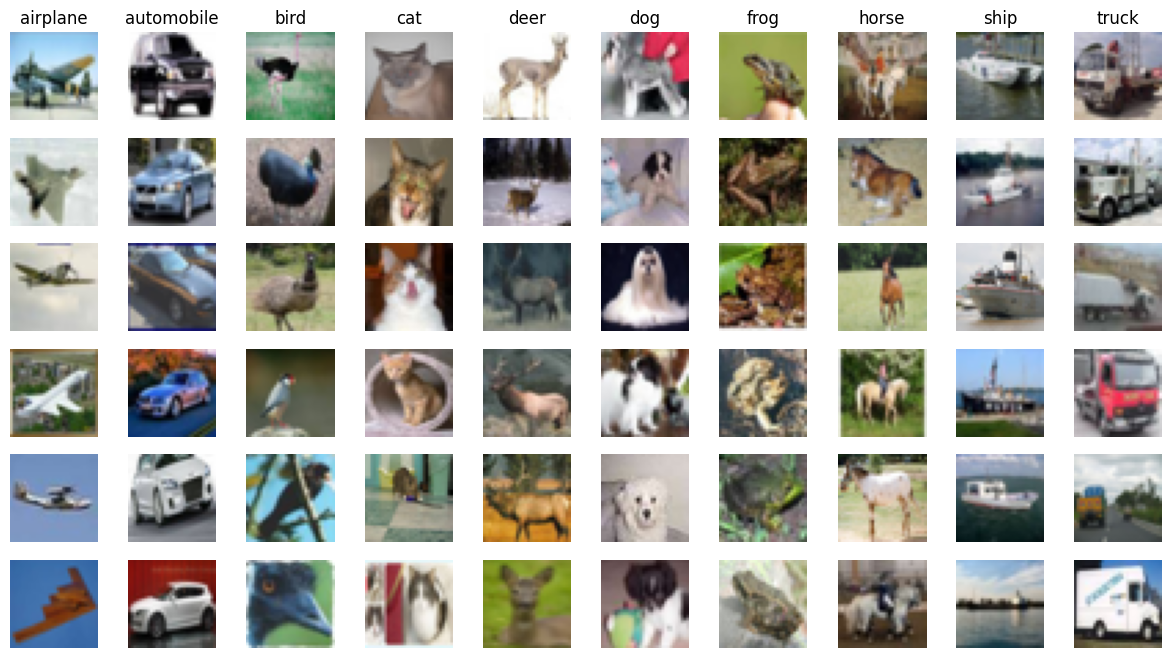

In [ ]:
reset_seed(42)

rows = 6
cols = 10
_, axs = plt.subplots(nrows=rows,ncols=cols, figsize=(15, 8))

for ax, col in zip(axs[0], labels):
    ax.set_title(col)

for col in range(cols):
    filtered = x_train[y_train == col]
    perm = torch.randperm(filtered.shape[0])
    subset = to_numpy(filtered[perm[:rows]]).transpose(0, 2, 3, 1)
    for row in range(rows):
        axs[row][col].grid("off")
        axs[row][col].axis("off")
        axs[row][col].imshow(subset[row])

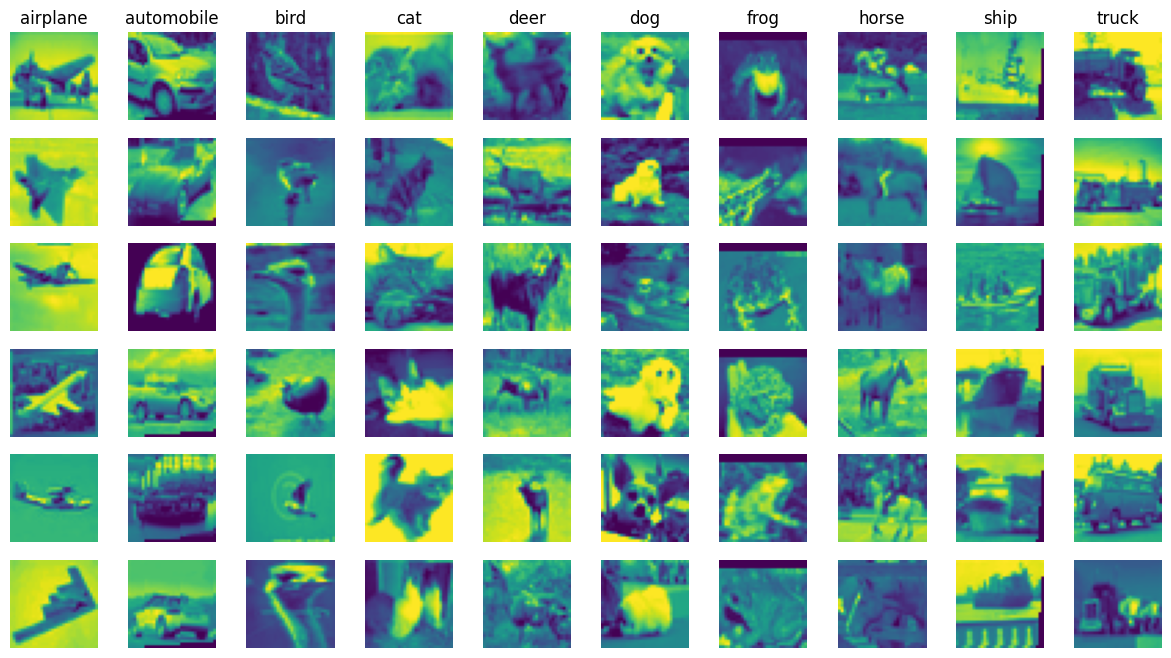

In [ ]:
reset_seed(42)

mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
jitter = 0.1

transform_train = v2.Compose([
    v2.RandomCrop(size=(32, 32)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandAugment(1, 8),
    v2.ColorJitter(jitter, jitter, jitter),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean, std),
])

transform_eval = v2.Compose([
    v2.ToDtype(torch.float32),
    v2.Normalize(mean, std),
])

rows = 6
cols = 10
_, axs = plt.subplots(nrows=rows,ncols=cols, figsize=(15, 8))

for ax, col in zip(axs[0], labels):
    ax.set_title(col)

for col in range(cols):
    filtered = x_train[y_train == col]
    perm = torch.randperm(filtered.shape[0])
    subset = transform_train(filtered[perm[:rows]])
    subset = to_numpy(subset).transpose(0, 2, 3, 1) / 255.
    for row in range(rows):
        axs[row][col].grid("off")
        axs[row][col].axis("off")
        axs[row][col].imshow(subset[row].mean(axis=2))

In [ ]:
reset_seed(42)

dataset = TensorDataset(x_train, y_train)
train_set, val_set = random_split(dataset, [0.8, 0.2])
test_set = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(val_set, batch_size=128, shuffle=False)

In [ ]:
class MixerBlock(nn.Module):
    def __init__(self, hidden, kernel):
        super(MixerBlock, self).__init__()
        self.depthwise_conv = nn.Conv2d(hidden, hidden, kernel, groups=hidden, padding='same')
        self.pointwise_conv = nn.Conv2d(hidden, hidden, 1)
        self.norm1 = nn.BatchNorm2d(hidden)
        self.norm2 = nn.BatchNorm2d(hidden)

    def forward(self, x):
        residual = x
        x = self.norm1(nn.functional.gelu(self.depthwise_conv(x)))
        x += residual
        x = self.norm2(nn.functional.gelu(self.pointwise_conv(x)))
        return x

class ConvMixer(nn.Module):
    def __init__(self, depth, hidden, kernel):
        super(ConvMixer, self).__init__()
        self.proj = nn.Conv2d(3, hidden, 2, stride=2)
        self.norm = nn.BatchNorm2d(hidden)

        self.blocks = nn.Sequential(*[
            MixerBlock(hidden, kernel)
            for _ in range(depth)
        ])

        self.pool = nn.AvgPool2d(16)
        self.linear = nn.Linear(hidden, 10)

    def forward(self, x):
        x = self.proj(x.view(-1, 3, 32, 32))
        x = self.norm(nn.functional.gelu(x))
        x = self.pool(self.blocks(x))
        x = self.linear(x.view(x.shape[0], -1))
        return x

In [ ]:
reset_seed(42)

epochs = 200
net = ConvMixer(8, 256, 5).to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

print("Number of parameter:", sum(x.numel() for x in net.parameters()))

best_acc = 0.0

for epoch in range(epochs):
    net.train()
    epoch_loss = torch.zeros(1, device=device)
    pbar = tqdm(train_loader)
    for i, (x_batch, y_batch) in enumerate(pbar):
        optimizer.zero_grad()
        y_hat = net(transform_train(x_batch))
        loss = nn.functional.cross_entropy(y_hat, y_batch)
        epoch_loss += loss.detach()

        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        pbar.set_description(f'Epoch: {epoch+1}/{epochs} | Train Loss: {(epoch_loss / (i + 1)).item():.4f}')

    with torch.no_grad():
        net.eval()
        val_loss = torch.zeros(1, device=device)
        val_acc  = torch.zeros(1, device=device)
        pbar = tqdm(val_loader)
        for i, (x_batch, y_batch) in enumerate(pbar):
            z = net(transform_eval(x_batch))
            loss = nn.functional.cross_entropy(z, y_batch)
            acc = (z.argmax(axis=1) == y_batch).float().mean()

            val_loss += loss.detach()
            val_acc += acc.detach()
            pbar.set_description(f'Validation Loss: {(val_loss / (i + 1)).item():.4f} - Accuracy: {(val_acc / (i + 1)).item():.4f}')
        epoch_acc = val_acc.item() / (i + 1)
        if epoch_acc > best_acc:
            print(f"Best model saved with accuracy: {epoch_acc}")
            best_acc = epoch_acc
            torch.save(net.state_dict(), "model.pth")

Number of parameter: 594186


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.4051621835443038


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.7005537974683544


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.743868670886076


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.8269382911392406


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.8414754746835443


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.866495253164557


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.8672863924050633


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.8718354430379747


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.8820213607594937


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.8878560126582279


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.8883504746835443


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.8918117088607594


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.892998417721519


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.8945806962025317


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.9037776898734177


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.903876582278481


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.9078322784810127


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.9091178797468354


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.9112935126582279


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.9113924050632911


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.913370253164557


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.9154469936708861


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.9170292721518988


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Best model saved with accuracy: 0.9197982594936709


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
def evaluate(net, loader):
    with torch.no_grad():
        net.eval()
        val_loss = torch.zeros(1, device=device)
        val_acc  = torch.zeros(1, device=device)
        pbar = tqdm(val_loader)
        for i, (x_batch, y_batch) in enumerate(pbar):
            z = net(transform_eval(x_batch))
            loss = nn.functional.cross_entropy(z, y_batch)
            acc = (z.argmax(axis=1) == y_batch).float().mean()

            val_loss += loss.detach()
            val_acc += acc.detach()
            pbar.set_description(f'Loss: {(val_loss / (i + 1)).item():.4f} - Accuracy: {(val_acc / (i + 1)).item():.4f}')
        return (val_loss / (i + 1)).item(), (val_acc / (i + 1)).item()

net.load_state_dict(torch.load("model.pth"))
val, acc = evaluate(net, test_loader)
print("Number of params:", sum(x.numel() for x in net.parameters()))
print("Test accuracy:", acc)

  0%|          | 0/79 [00:00<?, ?it/s]

Number of params: 594186
Test accuracy: 0.9197982549667358
